### Reference Notbooks
4. Natural language Processing IV (Section 5.4 thne 5.6)
4. NLP Exercise - do with student

### Steps to Follow
1. Try NaiveBayes classiffier first
2. Data Cleaning, lemming, etc
3. TFIDF
5. Try Random Forest (or K-means with only 2 clases?)

In [26]:
# Import necessary libraries
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# Importing the Training Data file
df= pd.read_csv('training_data_lowercase.csv', sep='\t', names=['tag', 'text'])

#Defining target and features
X = df['text']
y = df['tag']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
### Initialize resources and define Functions
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to get the correct WordNet POS tag
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,  # Adjectives
                "N": wordnet.NOUN,  # Nouns
                "V": wordnet.VERB,  # Verbs
                "R": wordnet.ADV}   # Adverbs
    return tag_dict.get(tag, wordnet.NOUN)  # Default to noun if POS not found

# Function to lemmatize tokens with POS tags
def lemmatize_text(tokens):
    return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]

# Function for flexible preprocessing
def preprocess_text(text, clean=True, tokenize=True, lemmatize=True, remove_stopwords=True):
    # Step 1: Basic Cleaning (lowercasing and removing non-alphabetic characters)
    if clean:
        text = ' '.join([word.lower() for word in word_tokenize(text) if word.isalpha()])  # Join words with spaces

    # Step 2: Tokenization
    if tokenize:
        text = word_tokenize(text)
    else:
        text = text.split()  # Split into words even if not tokenizing with NLTK

    # Step 3: Stopword Removal
    if remove_stopwords:
        text = [word for word in text if word not in stop_words]

    # Step 4: Lemmatization with POS tagging
    if lemmatize:
        text = lemmatize_text(text)

    # Return processed text
    return text

In [29]:
# Preprocess training and test sets
X_train_clean = X_train.apply(lambda x: preprocess_text(x,
                                                        clean=True,
                                                        tokenize=True,
                                                        lemmatize=True,
                                                        remove_stopwords=False))
X_test_clean = X_test.apply(lambda x: preprocess_text(x,
                                                      clean=True,
                                                      tokenize=True,
                                                      lemmatize=True,
                                                      remove_stopwords=False))

In [30]:
# Join the tokens back into strings for vectorization
X_train_final = X_train_clean.apply(lambda tokens: " ".join(tokens))
X_test_final = X_test_clean.apply(lambda tokens: " ".join(tokens))

In [31]:
X_train_clean

8891                                                  [so]
25115    [final, reckoning, approaches, for, obama's, h...
26933    [illinois, budget, talks, fizzle, amid, partis...
26971    [clinton, spokesman:, ig, report, shows, no, c...
11387    [busted!, nancy, pelosi, claims, no, meeting, ...
                               ...                        
16850                  [senate, passes, usa, freedom, act]
6265     [oklahoma, republicans, are, trying, to, impea...
11284    [texas, congressman, lets, screaming, leftist,...
860      [trump, stole, an, idea, from, north, korean, ...
15795    [outrageous!, nancy, pelosi, claims, obamacare...
Name: text, Length: 27321, dtype: object

In [32]:
X_train_final

8891                                                    so
25115    final reckoning approaches for obama's high co...
26933    illinois budget talks fizzle amid partisan ent...
26971    clinton spokesman: ig report shows no clinton ...
11387    busted! nancy pelosi claims no meeting with ru...
                               ...                        
16850                        senate passes usa freedom act
6265     oklahoma republicans are trying to impeach oba...
11284    texas congressman lets screaming leftist agita...
860      trump stole an idea from north korean propagan...
15795    outrageous! nancy pelosi claims obamacare hono...
Name: text, Length: 27321, dtype: object

In [33]:
### VECTORIZATION
# Vectorization using Bag of Words
bow_vect = CountVectorizer(max_features=1000)

# Fit and transform the training data, transform the test data
X_train_vect = bow_vect.fit_transform(X_train_final).toarray()
X_test_vect = bow_vect.transform(X_test_final).toarray()

# TF-IDF Vectorization
tfidf_vect = TfidfVectorizer(max_features=1000, ngram_range=(1,2))

# Fit and transform the training data, transform the test data
X_train_tfidf = tfidf_vect.fit_transform(X_train_final).toarray()
X_test_tfidf = tfidf_vect.transform(X_test_final).toarray()

In [ ]:
# TODO: Explain we wanted more beautiful functions.

In [34]:
### TRAINING AND PREDICTING WITH DIFFERENT MODELS (bag of words)

# Logistic Regression
lr_model_bow = LogisticRegression(max_iter=1000).fit(X_train_vect, y_train)
y_pred_lr_bow = lr_model_bow.predict(X_test_vect)

# Support Vector Machine (SVM)
svm_model_bow = SVC(kernel='linear', random_state=42).fit(X_train_vect, y_train)
y_pred_svm_bow = svm_model_bow.predict(X_test_vect)

# Naive Bayes classifier
nb_model_bow = MultinomialNB().fit(X_train_vect, y_train)
y_pred_nb_bow = nb_model_bow.predict(X_test_vect)

# XGB Classifier
xgb_model_bow = XGBClassifier(random_state=42).fit(list(X_train_vect), y_train)
y_pred_xgb_bow = xgb_model_bow.predict(list(X_test_vect))

In [35]:
### TRAINING AND PREDICTING WITH DIFFERENT MODELS (TF-IDF)

# Logistic Regression
lr_model_tfidf = LogisticRegression(max_iter=1000).fit(X_train_tfidf, y_train)
y_pred_lr_tfidf = lr_model_tfidf.predict(X_test_tfidf)

# Support Vector Machine (SVM)
svm_model_tfidf = SVC(kernel='linear', random_state=42).fit(X_train_tfidf, y_train)
y_pred_svm_tfidf = svm_model_tfidf.predict(X_test_tfidf)

# Naive Bayes classifier
nb_model_tfidf = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred_nb_tfidf = nb_model_tfidf.predict(X_test_tfidf)

# XGB Classifier
xgb_model_tfidf = XGBClassifier(random_state=42).fit(list(X_train_tfidf), y_train)
y_pred_xgb_tfidf = xgb_model_tfidf.predict(list(X_test_tfidf))

In [ ]:
# Optional: Save models for future use
""" import pickle
with open('svm_model_w2v.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

with open('logreg_model_w2v.pkl', 'wb') as f:
    pickle.dump(logreg_model, f)

with open('rf_model_w2v.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('xgb_model_w2v.pkl', 'wb') as f:
    pickle.dump(xgb_model, f) """

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [11]:
# Define 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# Perform cross-validation and compute accuracy for each fold
cv_scores = cross_val_score(nb_model_tfidf, X_train_tfidf, y_train, cv=kfold, scoring='accuracy')
# Print the average accuracy and standard deviation across folds
print(f"Cross-validated Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

Cross-validated Mean Accuracy: 0.9029
Standard Deviation: 0.0046


In [38]:
### EVALUATION (Bag of Words)
print("BAG OF WORDS (No Clean, No Tokenized, No Lemmatized, No StopWords removal)"),
acc_score_lr = accuracy_score(y_test, y_pred_lr_bow)
print(f"Accuracy Score Log Regression: {acc_score_lr:.4f}")
report_lr = classification_report(y_test, y_pred_lr_bow)
#print("Classification Report Log Regression:\n", report_lr)

acc_score_svm = accuracy_score(y_test, y_pred_svm_bow)
print(f"Accuracy Score SVM: {acc_score_svm:.4f}")
report_svm = classification_report(y_test, y_pred_svm_bow)
#print("Classification Report SVM:\n", report_svm)

acc_score_nb = accuracy_score(y_test, y_pred_nb_bow)
print(f"Accuracy Score Naive Bayes: {acc_score_nb:.4f}")
report_nb = classification_report(y_test, y_pred_nb_bow)
#print("Classification Report Naive Bayes:\n", report_nb)

acc_score_xgb = accuracy_score(y_test, y_pred_xgb_bow)
print(f"Accuracy Score XGB Classifier: {acc_score_xgb:.4f}")
report_xgb = classification_report(y_test, y_pred_xgb_bow)
#print("Classification Report XGB Classifier:\n", report_xgb)

BAG OF WORDS (No Clean, No Tokenized, No Lemmatized, No StopWords removal)
Accuracy Score Log Regression: 0.9268
Accuracy Score SVM: 0.9250
Accuracy Score Naive Bayes: 0.9179
Accuracy Score XGB Classifier: 0.9084


In [39]:
### EVALUATION (TF_IDF)
print("TF-IDF  (No Clean, No Tokenized, No Lemmatized, No StopWords removal)")
acc_score_lr = accuracy_score(y_test, y_pred_lr_tfidf)
print(f"Accuracy Score Log Regression: {acc_score_lr:.4f}")
report_lr = classification_report(y_test, y_pred_lr_tfidf)
#print("Classification Report Log Regression:\n", report_lr)

acc_score_svm = accuracy_score(y_test, y_pred_svm_tfidf)
print(f"Accuracy Score SVM: {acc_score_svm:.4f}")
report_svm = classification_report(y_test, y_pred_svm_tfidf)
#print("Classification Report SVM:\n", report_svm)

acc_score_nb = accuracy_score(y_test, y_pred_nb_tfidf)
print(f"Accuracy Score Naive Bayes: {acc_score_nb:.4f}")
report_nb = classification_report(y_test, y_pred_nb_tfidf)
#print("Classification Report Naive Bayes:\n", report_nb)

acc_score_xgb = accuracy_score(y_test, y_pred_xgb_tfidf)
print(f"Accuracy Score XGB Classifier: {acc_score_xgb:.4f}")
report_xgb = classification_report(y_test, y_pred_xgb_tfidf)
#print("Classification Report XGB Classifier:\n", report_xgb)

TF-IDF  (No Clean, No Tokenized, No Lemmatized, No StopWords removal)
Accuracy Score Log Regression: 0.9248
Accuracy Score SVM: 0.9256
Accuracy Score Naive Bayes: 0.9091
Accuracy Score XGB Classifier: 0.9070


In [ ]:
# TODO:  Dicctionaries of Models -> Dataframe -> Plots

dict_models = {
    'Logistic Regression': {
        Accuracy Score BoW: acc_score_lr,
        Report BoW: acc_score_lr,
        Accuracy Score TF-IDF: report_lr,
        Report TF-IDF: report_lr}
    'SVM': report_svm,
    'Naive Bayes': report_nb,
    'XGB Classifier': report_xgb
}

df_models = pd.DataFrame.from_dict(dict_models, orient='index', columns=['Classification Report'])
df_models

                     Bag of Words  TF-IDF
Logistic Regression        0.9259  0.9258
SVM                        0.9264  0.9264
Naive Bayes                0.9173  0.9107
XGB Classifier             0.9046  0.9041


<Figure size 1000x600 with 0 Axes>

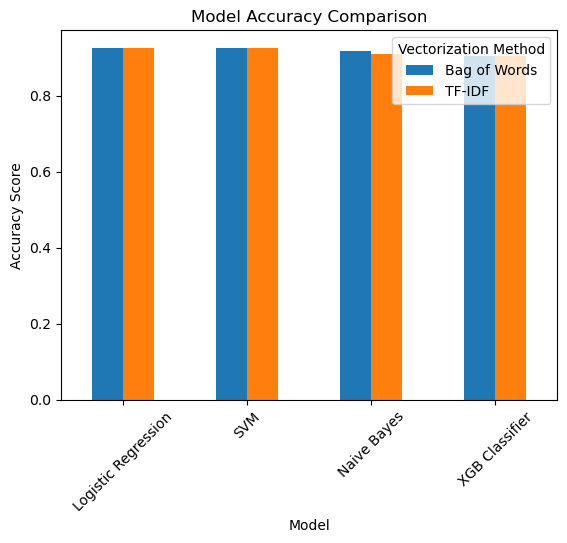

In [40]:
# Initialize a dictionary to hold the accuracy scores for each model and vectorization method
model_results = {
    'Bag of Words': {
        'Logistic Regression': 0.9259,
        'SVM': 0.9264,
        'Naive Bayes': 0.9173,
        'XGB Classifier': 0.9046
    },
    'TF-IDF': {
        'Logistic Regression': 0.9258,  # Update these with TF-IDF scores
        'SVM': 0.9264,
        'Naive Bayes': 0.9107,
        'XGB Classifier': 0.9041
    }
}

# Convert dictionary into a pandas DataFrame
results_df = pd.DataFrame(model_results)
# View the DataFrame
print(results_df)

# Plot the results using seaborn
plt.figure(figsize=(10, 6))
results_df.plot(kind='bar', rot=0)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Vectorization Method')
plt.show()